In [1]:
"""
    This notebook is used to generate the figures for the following section:
    "The Iterative Compensation Algorithm"
"""

'\n    This notebook is used to generate the figures for the following section:\n    "The Iterative Compensation Algorithm"\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

from stg import simulate_individual_t_eval, get_default_u0, get_default_parameters
import warnings
from stg import DICs


# fix the seed for reproducibility
np.random.seed(42)


100%|██████████| 10000/10000 [00:00<00:00, 120901.88it/s]


(4, 10000)
(10000, 8)
(10000,) (10000,) (10000,)


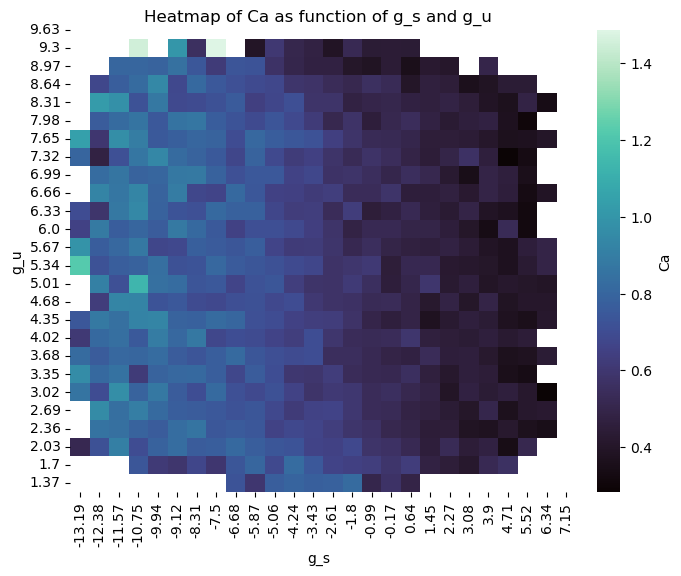

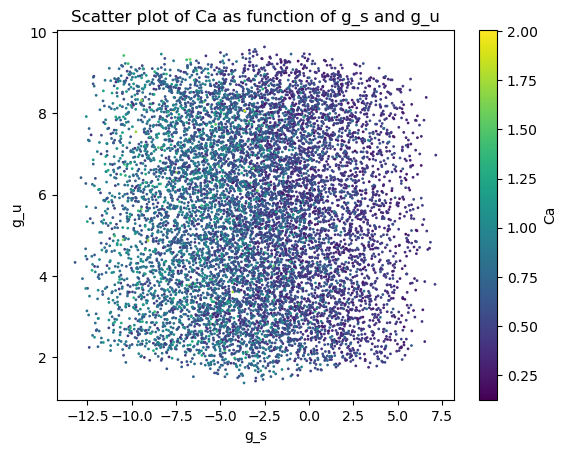

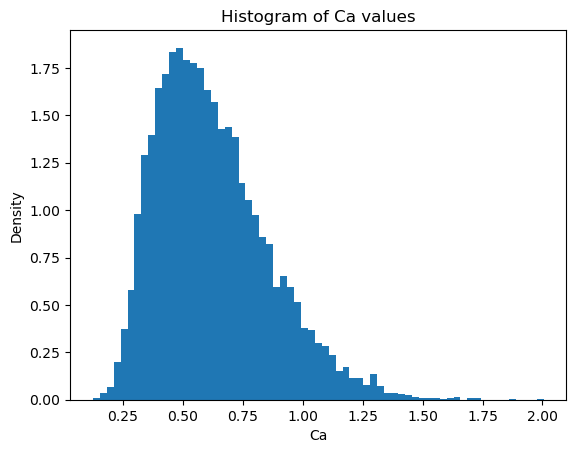

Fitted model: Ca = -0.0300 * g_s + -0.0049 * g_u + 0.5630
R^2: 0.2645


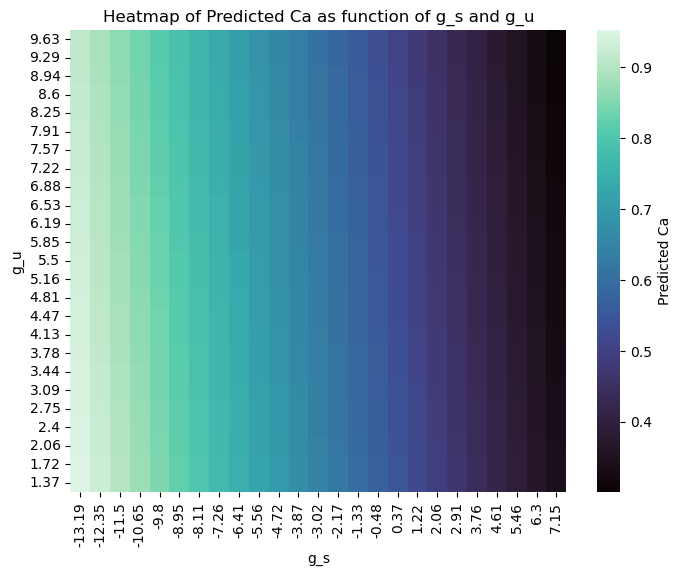

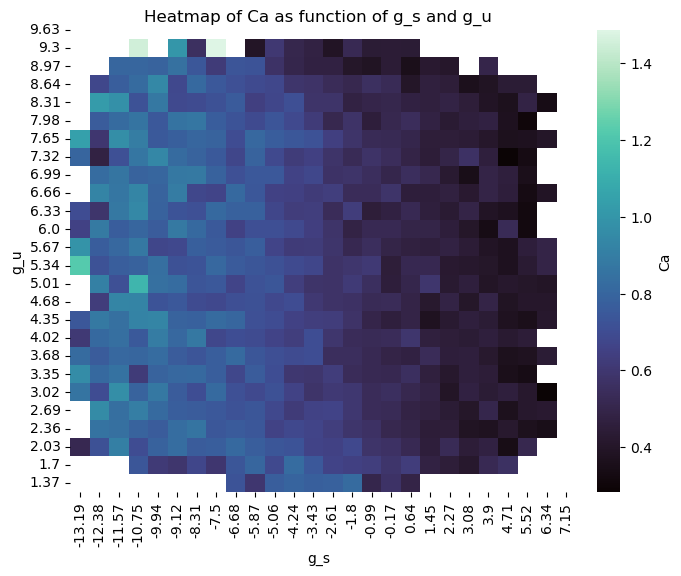

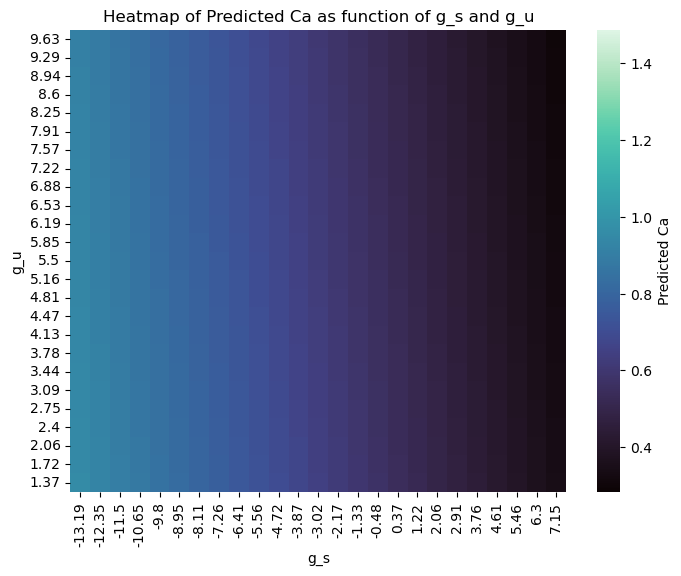

In [3]:
from utils import gamma_uniform_mean_std_matching
def get_individual(f=1/4):
    g_bar_range_Na = [0, 8000]
    g_bar_range_Kd = [0, 350]
    g_bar_range_CaT = [0, 12]
    g_bar_range_CaS = [0, 50]
    g_bar_range_KCa = [0, 250]
    g_bar_range_A = [0, 600]
    g_bar_range_H = [0, 0.7]
    g_bar_range_leak = [0, 0.02]

    g_bar_range_Na = [g_bar_range_Na[0] + (g_bar_range_Na[1] - g_bar_range_Na[0])*f, g_bar_range_Na[1] - (g_bar_range_Na[1] - g_bar_range_Na[0])*f]
    g_bar_range_Kd = [g_bar_range_Kd[0] + (g_bar_range_Kd[1] - g_bar_range_Kd[0])*f, g_bar_range_Kd[1] - (g_bar_range_Kd[1] - g_bar_range_Kd[0])*f]
    g_bar_range_CaT = [g_bar_range_CaT[0] + (g_bar_range_CaT[1] - g_bar_range_CaT[0])*f, g_bar_range_CaT[1] - (g_bar_range_CaT[1] - g_bar_range_CaT[0])*f]
    g_bar_range_CaS = [g_bar_range_CaS[0] + (g_bar_range_CaS[1] - g_bar_range_CaS[0])*f, g_bar_range_CaS[1] - (g_bar_range_CaS[1] - g_bar_range_CaS[0])*f]
    g_bar_range_KCa = [g_bar_range_KCa[0] + (g_bar_range_KCa[1] - g_bar_range_KCa[0])*f, g_bar_range_KCa[1] - (g_bar_range_KCa[1] - g_bar_range_KCa[0])*f]
    g_bar_range_A = [g_bar_range_A[0] + (g_bar_range_A[1] - g_bar_range_A[0])*f, g_bar_range_A[1] - (g_bar_range_A[1] - g_bar_range_A[0])*f]
    g_bar_range_H = [g_bar_range_H[0] + (g_bar_range_H[1] - g_bar_range_H[0])*f, g_bar_range_H[1] - (g_bar_range_H[1] - g_bar_range_H[0])*f]
    g_bar_range_leak = [g_bar_range_leak[0] + (g_bar_range_leak[1] - g_bar_range_leak[0])*f, g_bar_range_leak[1] - (g_bar_range_leak[1] - g_bar_range_leak[0])*f]
    g_bar_leak_gamma = gamma_uniform_mean_std_matching(*g_bar_range_leak)

    g_leak = np.random.gamma(g_bar_leak_gamma[0], g_bar_leak_gamma[1]) 
    g_Na = np.random.uniform(*g_bar_range_Na) * g_leak/0.01
    g_Kd = np.random.uniform(*g_bar_range_Kd) * g_leak/0.01
    g_CaT = np.random.uniform(*g_bar_range_CaT)  * g_leak/0.01
    g_CaS = np.random.uniform(*g_bar_range_CaS) * g_leak/0.01
    g_KCa = np.random.uniform(*g_bar_range_KCa) * g_leak/0.01
    g_A = np.random.uniform(*g_bar_range_A) * g_leak/0.01
    g_H = np.random.uniform(*g_bar_range_H) * g_leak/0.01
    return np.array([g_Na, g_Kd, g_CaT, g_CaS, g_KCa, g_A, g_H, g_leak])

N = 10000
V_th = -51.
populations = []
dics = []

from tqdm import tqdm
from stg import compute_equilibrium_Ca, m_inf_Na, h_inf_Na, m_inf_Kd, m_inf_CaT, h_inf_CaT, m_inf_CaS, h_inf_CaS

for i in tqdm(range(N)):
    individual = get_individual(f=1/4)
    populations.append(individual)

populations = np.array(populations)

dics = DICs(V_th, *(populations.T), **get_default_parameters())
dics = np.array(dics).squeeze()
print(dics.shape)

alpha_Ca = get_default_parameters()['alpha_Ca']
beta_Ca = get_default_parameters()['beta_Ca']
E_Ca = get_default_parameters()['E_Ca']

g_CaS = populations[:,3]
g_CaT = populations[:,2]
print(populations.shape)

V = np.atleast_2d(V_th).T

m_inf_CaT_values = m_inf_CaT(V)
h_inf_CaT_values = h_inf_CaT(V)
m_inf_CaS_values = m_inf_CaS(V)
h_inf_CaS_values = h_inf_CaS(V)

I_CaT = g_CaT * m_inf_CaT_values**3 * h_inf_CaT_values * (V - E_Ca)
I_CaS = g_CaS * m_inf_CaS_values**3 * h_inf_CaS_values * (V - E_Ca)

I_Ca = I_CaT + I_CaS
Ca = compute_equilibrium_Ca(alpha_Ca, I_Ca, beta_Ca).squeeze()

# make a g_s - g_u, z = Ca heat map
g_s = dics[1]
g_u = dics[2]
z = Ca

print(g_s.shape, g_u.shape, z.shape)

df = pd.DataFrame({'g_s': g_s, 'g_u': g_u, 'z': z})

from scipy.stats import binned_statistic_2d

# Bin the data to create a grid
bins = 25  # Adjust the number of bins for resolution
stat, x_edges, y_edges, _ = binned_statistic_2d(df['g_s'], df['g_u'], df['z'], statistic='mean', bins=bins)

# Create a heatmap plot
plt.figure(figsize=(8, 6))
sns.heatmap(stat.T, 
            xticklabels=np.round(x_edges, 2), 
            yticklabels=np.round(y_edges, 2), 
            cmap="mako",  # Pastel colormap
            cbar_kws={'label': 'Ca'},
            rasterized=False)
# flip the y-axis
plt.gca().invert_yaxis()

plt.xlabel('g_s')
plt.ylabel('g_u')
plt.title('Heatmap of Ca as function of g_s and g_u')
# save as svg
plt.savefig('figures/heatmap_Ca.svg')
plt.show()


# make a scatter plot of g_s - g_u, z = Ca
plt.figure()
plt.scatter(df['g_s'], df['g_u'], c=df['z'], cmap='viridis', s=1)
plt.colorbar(label='Ca')
plt.xlabel('g_s')
plt.ylabel('g_u')
plt.title('Scatter plot of Ca as function of g_s and g_u')
#plt.savefig('figures/scatter_Ca.svg')
plt.show()

# do a histogram of the Ca values
plt.figure()
plt.hist(z, bins='auto', density=True)
plt.xlabel('Ca')
plt.ylabel('Density')
plt.title('Histogram of Ca values')
#plt.savefig('figures/histogram_Ca.svg')
plt.show()

from sklearn.linear_model import LinearRegression
# Fit a linear model: Ca = a * g_s + b * g_u + c
X = df[['g_s', 'g_u']]
y = df['z']

model = LinearRegression()
model.fit(X, y)

a, b = model.coef_
c = model.intercept_
print(f"Fitted model: Ca = {a:.4f} * g_s + {b:.4f} * g_u + {c:.4f}")

# Generate a grid of values for g_s and g_u
g_s_grid, g_u_grid = np.meshgrid(np.linspace(df['g_s'].min(), df['g_s'].max(), bins),
                                 np.linspace(df['g_u'].min(), df['g_u'].max(), bins))

# Convert the grid into a DataFrame with correct feature names
grid_df = pd.DataFrame(np.c_[g_s_grid.ravel(), g_u_grid.ravel()], columns=['g_s', 'g_u'])

# Predict Ca values on the grid
Ca_pred = model.predict(grid_df).reshape(g_s_grid.shape)
# fit a linear model Ca = a * g_s + b * g_u + c

# print the R^2 value
print(f"R^2: {model.score(X, y):.4f}")

# Create a heatmap of the predicted values
plt.figure(figsize=(8, 6))
sns.heatmap(Ca_pred, 
            xticklabels=np.round(np.linspace(df['g_s'].min(), df['g_s'].max(), bins), 2),
            yticklabels=np.round(np.linspace(df['g_u'].min(), df['g_u'].max(), bins), 2),
            cmap='mako', 
            cbar_kws={'label': 'Predicted Ca'},
            rasterized=False)

# flip the y-axis
plt.gca().invert_yaxis()

plt.xlabel('g_s')
plt.ylabel('g_u')
plt.title('Heatmap of Predicted Ca as function of g_s and g_u')
plt.savefig('figures/heatmap_predicted_Ca.svg')
plt.show()

# Calculate the global min and max for the color limits
clim_min = np.nanmin(stat)
clim_max = np.nanmax(stat)

# Create a heatmap of the actual Ca values
plt.figure(figsize=(8, 6))
sns.heatmap(stat.T, 
            xticklabels=np.round(x_edges, 2), 
            yticklabels=np.round(y_edges, 2), 
            cmap="mako",  # Pastel colormap
            cbar_kws={'label': 'Ca'},
            rasterized=False,
            vmin=clim_min, vmax=clim_max)  # Set shared color limits
# Flip the y-axis
plt.gca().invert_yaxis()

plt.xlabel('g_s')
plt.ylabel('g_u')
plt.title('Heatmap of Ca as function of g_s and g_u')
plt.savefig('figures/heatmap_Ca.svg')
plt.show()

# Create a heatmap of the predicted Ca values
plt.figure(figsize=(8, 6))
sns.heatmap(Ca_pred, 
            xticklabels=np.round(np.linspace(df['g_s'].min(), df['g_s'].max(), bins), 2),
            yticklabels=np.round(np.linspace(df['g_u'].min(), df['g_u'].max(), bins), 2),
            cmap='mako', 
            cbar_kws={'label': 'Predicted Ca'},
            rasterized=False,
            vmin=clim_min, vmax=clim_max)  # Set shared color limits
# Flip the y-axis
plt.gca().invert_yaxis()

plt.xlabel('g_s')
plt.ylabel('g_u')
plt.title('Heatmap of Predicted Ca as function of g_s and g_u')
plt.savefig('figures/heatmap_predicted_Ca.svg')
plt.show()


100%|██████████| 5000/5000 [00:10<00:00, 482.13it/s]


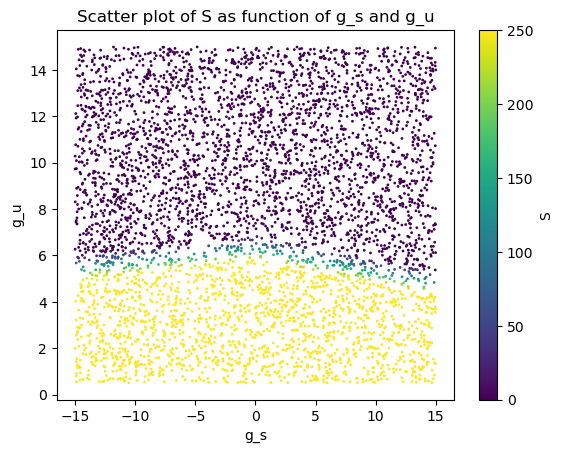

In [4]:
# The goal will be to compare the residual of the Fyon method, the Target-dependent prior Method and the Iterative Compensation Algorithm

# First, we will generate the residuals of the Fyon method
N_population = 5000
M = 250
V_th = -51.
g_s_range = [-15, 15]
g_u_range = [0.5, 15]
g_s_targets = np.random.uniform(*g_s_range, N_population)
g_u_targets = np.random.uniform(*g_u_range, N_population)

from stg import generate_neuromodulated_population

populations = []
S = []
for i in tqdm(range(N_population)):
    p = generate_neuromodulated_population(M, V_th, g_s_targets[i], g_u_targets[i], set_to_compensate=['CaS', 'A'], use_fitted_gCaS=lambda x,y: 10.)
    populations.append(p)
    S.append(len(p))

# scatter plot of g_s - g_u, z = S
S = np.array(S)
df = pd.DataFrame({'g_s': g_s_targets, 'g_u': g_u_targets, 'z': S})

# Create a heatmap plot
plt.figure()
plt.scatter(df['g_s'], df['g_u'], c=df['z'], cmap='viridis', s=1)
plt.colorbar(label='S')
plt.xlabel('g_s')
plt.ylabel('g_u')
plt.title('Scatter plot of S as function of g_s and g_u')
plt.show()


100%|██████████| 5000/5000 [00:01<00:00, 3097.52it/s]


Number of residuals: 1633


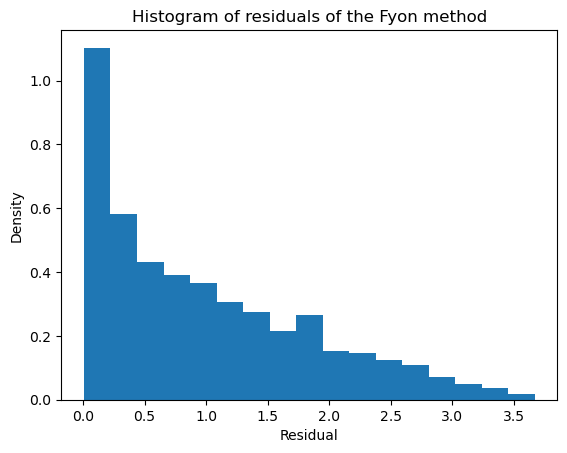

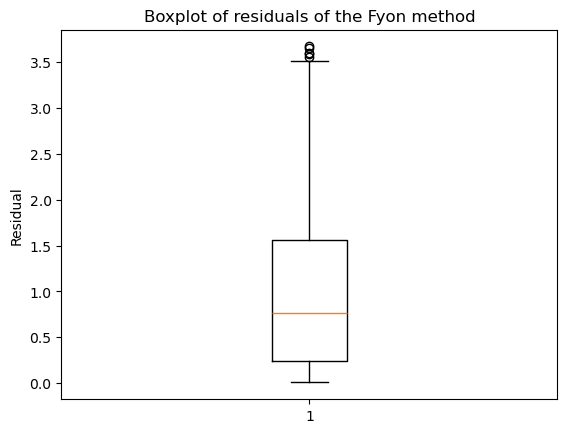

In [5]:
# compute the dics
residuals = []

for i in tqdm(range(N_population)):
    if len(populations[i]) < M:
        continue
    dics = DICs(V_th, *(populations[i].T), **get_default_parameters())
    dics = np.array(dics).squeeze()
    g_s = dics[1]
    g_u = dics[2]
    g = np.array([g_s, g_u])
    r = g - np.array([g_s_targets[i], g_u_targets[i]]).reshape(2, 1)
    r = np.linalg.norm(r, axis=0) # norm L2
    residuals.append(np.mean(r))

print(f"Number of residuals: {len(residuals)}")

# hist of the residuals

plt.figure()
plt.hist(residuals, bins='auto', density=True)
plt.xlabel('Residual')
plt.ylabel('Density')
plt.title('Histogram of residuals of the Fyon method')
plt.show()

# boxplot of the residuals
plt.figure()
plt.boxplot(residuals)
plt.ylabel('Residual')
plt.title('Boxplot of residuals of the Fyon method')
plt.show()

residuals_fyon = residuals

100%|██████████| 5000/5000 [00:07<00:00, 711.19it/s]


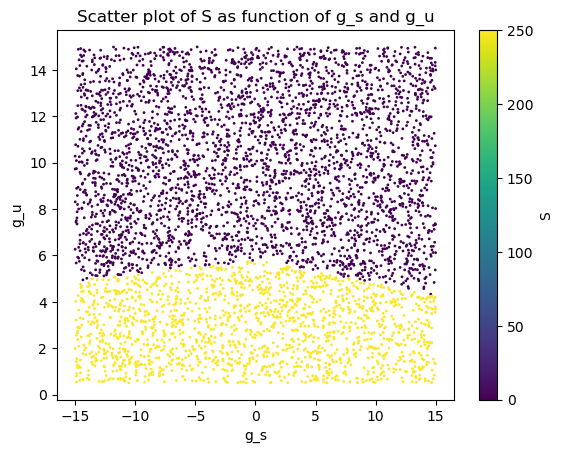

In [6]:
# Now we use the fitted Ca to get the default g_CaS and compare the residuals

def compute_gCaS_from_Ca(Ca, g_CaT, V = -51.):
    #   I_CaT = g_CaT * m_CaT**3 * h_CaT * (V - E_Ca)
    #   I_CaS = g_CaS * m_CaS**3 * h_CaS * (V - E_Ca)
    #   Ca = -alpha * I_Ca + beta
    # ==> g_CaS = [(Ca - beta) / (-alpha) - g_CaT * m_CaT**3 * h_CaT * (V-E_Ca)] / (m_CaS**3 * h_CaS * (V-E_Ca))
    alpha = get_default_parameters()['alpha_Ca']
    beta = get_default_parameters()['beta_Ca']
    E_Ca = get_default_parameters()['E_Ca']
    m_CaT = m_inf_CaT(V)
    h_CaT = h_inf_CaT(V)
    m_CaS = m_inf_CaS(V)
    h_CaS = h_inf_CaS(V)
    g_CaS = ((Ca - beta) / (-alpha) - g_CaT * m_CaT**3 * h_CaT * (V-E_Ca)) / (m_CaS**3 * h_CaS * (V-E_Ca))
    return g_CaS

from stg import generate_spiking_population, modulate_population

populations = []
for i in tqdm(range(N_population)):
    p = generate_spiking_population(M, V_th)
    if S[i] < M:
        populations.append([])
        continue
    g_CaT = p[:, 2]
    # Ca_pred from the linear model
    a = model.coef_[0]
    b = model.coef_[1]
    c = model.intercept_
    Ca_pred = c + a*g_s_targets[i] + b*g_u_targets[i] 
    Ca_pred = np.clip(Ca_pred, 0, None)   
    g_CaS = compute_gCaS_from_Ca(Ca_pred, g_CaT)
    g_CaS = np.clip(g_CaS, 0, None)
    p = modulate_population(p.copy(), -51., None, g_s_targets[i], g_u_targets[i], get_default_parameters(), ['CaS', 'A'], default_g_CaS_for_Ca=g_CaS)
    p = p[np.all(p >= 0, axis=1)]
    populations.append(p)

# scatter plot of g_s - g_u, z = S
S = np.array([len(p) for p in populations])
df = pd.DataFrame({'g_s': g_s_targets, 'g_u': g_u_targets, 'z': S})

# Create a scatter plot of g_s - g_u, z = S
plt.figure()
plt.scatter(df['g_s'], df['g_u'], c=df['z'], cmap='viridis', s=1)
plt.colorbar(label='S')
plt.xlabel('g_s')
plt.ylabel('g_u')
plt.title('Scatter plot of S as function of g_s and g_u')
plt.show()

100%|██████████| 5000/5000 [00:01<00:00, 3149.20it/s]


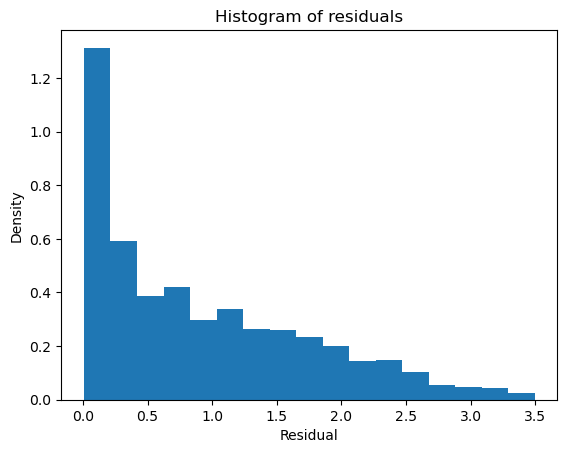

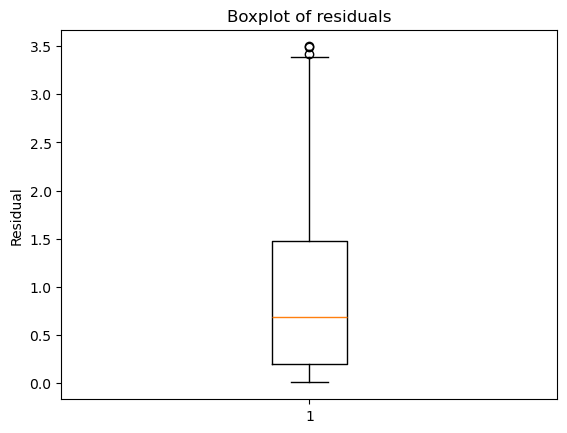

In [7]:
# compute the dics
residuals = []

for i in tqdm(range(N_population)):
    if len(populations[i]) < M:
        continue
    dics = DICs(V_th, *(populations[i].T), **get_default_parameters())
    dics = np.array(dics).squeeze()
    g_s = dics[1]
    g_u = dics[2]
    g = np.array([g_s, g_u])
    r = g - np.array([g_s_targets[i], g_u_targets[i]]).reshape(2, 1)
    r = np.linalg.norm(r, axis=0)  # norm L2
    residuals.append(np.mean(r))

# Histogram of the residuals
plt.figure()
plt.hist(residuals, bins='auto', density=True)
plt.xlabel('Residual')
plt.ylabel('Density')
plt.title('Histogram of residuals')
plt.show()

# Boxplot of the residuals
plt.figure()
plt.boxplot(residuals)
plt.ylabel('Residual')
plt.title('Boxplot of residuals')
plt.show()

residuals_target_dependent = residuals

Mean residual Fyon: 0.9801
Mean residual Target-dependent: 0.9151


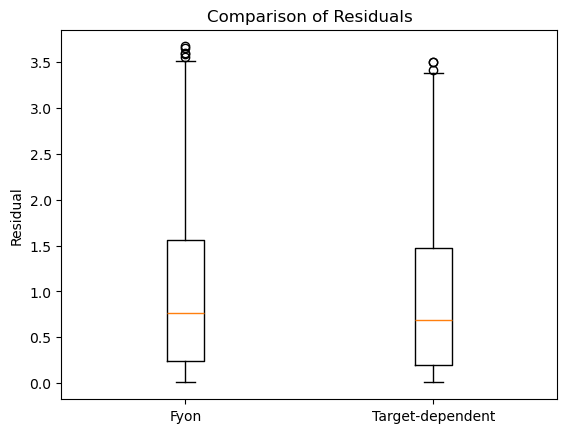

In [8]:
#compare the residuals
plt.figure()
plt.boxplot([residuals_fyon, residuals_target_dependent], tick_labels=['Fyon', 'Target-dependent'])
plt.ylabel('Residual')
plt.title('Comparison of Residuals')

print(f"Mean residual Fyon: {np.mean(residuals_fyon):.4f}")
print(f"Mean residual Target-dependent: {np.mean(residuals_target_dependent):.4f}")

100%|██████████| 5000/5000 [00:04<00:00, 1002.05it/s]


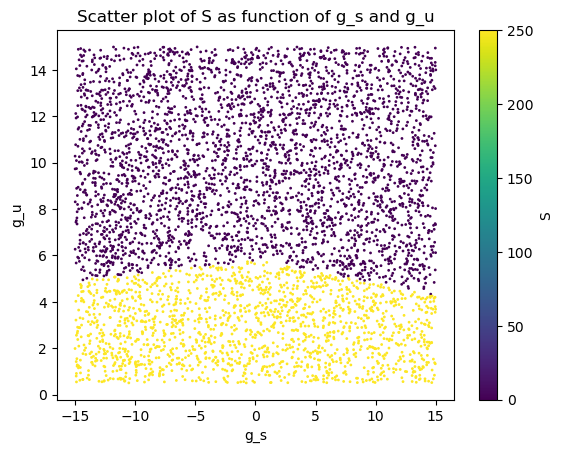

100%|██████████| 5000/5000 [00:01<00:00, 3201.52it/s]


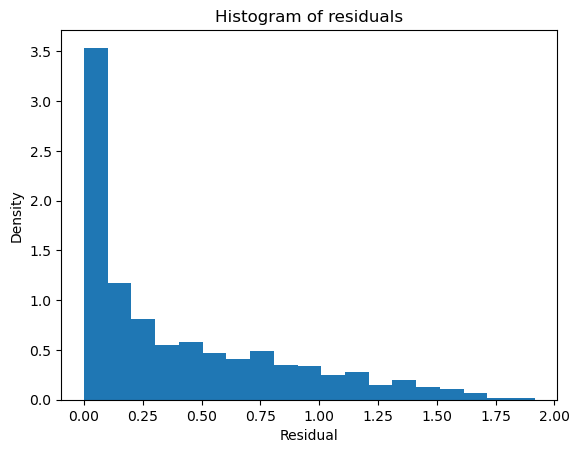

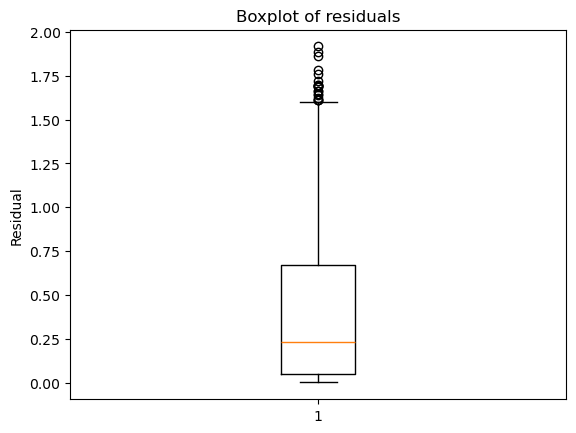

In [9]:
# now we use the Iterative Compensation Algorithm

populations = []

for i in tqdm(range(N_population)):
    if S[i] < M:
        populations.append([])
        continue
    p = generate_neuromodulated_population(M, V_th, g_s_targets[i], g_u_targets[i], set_to_compensate=['CaS', 'A'], iterations=1)
    populations.append(p)

# scatter plot of g_s - g_u, z = S
S = np.array([len(p) for p in populations])
df = pd.DataFrame({'g_s': g_s_targets, 'g_u': g_u_targets, 'z': S})

# Create a scatter plot of g_s - g_u, z = S
plt.figure()
plt.scatter(df['g_s'], df['g_u'], c=df['z'], cmap='viridis', s=1)
plt.colorbar(label='S')
plt.xlabel('g_s')
plt.ylabel('g_u')
plt.title('Scatter plot of S as function of g_s and g_u')
plt.show()

# compute the dics

residuals = []

for i in tqdm(range(N_population)):
    if len(populations[i]) < M:
        continue
    dics = DICs(V_th, *(populations[i].T), **get_default_parameters())
    dics = np.array(dics).squeeze()
    g_s = dics[1]
    g_u = dics[2]
    g = np.array([g_s, g_u])
    r = g - np.array([g_s_targets[i], g_u_targets[i]]).reshape(2, 1)
    r = np.linalg.norm(r, axis=0)  # norm L2
    residuals.append(np.mean(r))

# Histogram of the residuals
plt.figure()
plt.hist(residuals, bins='auto', density=True)
plt.xlabel('Residual')
plt.ylabel('Density')
plt.title('Histogram of residuals')
plt.show()

# Boxplot of the residuals
plt.figure()
plt.boxplot(residuals)
plt.ylabel('Residual')
plt.title('Boxplot of residuals')
plt.show()

residuals_iterative_1_it = residuals

100%|██████████| 5000/5000 [00:06<00:00, 743.99it/s]


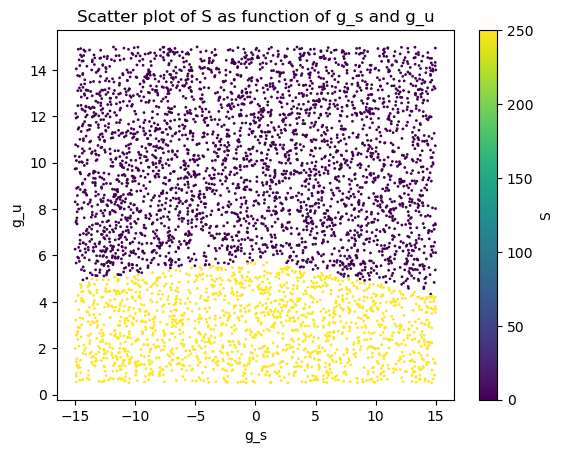

100%|██████████| 5000/5000 [00:01<00:00, 3193.15it/s]


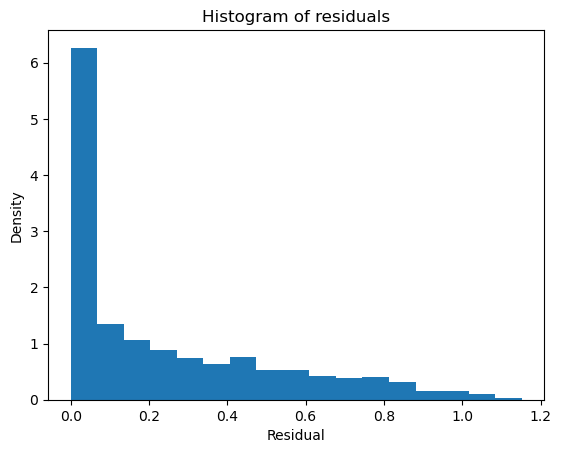

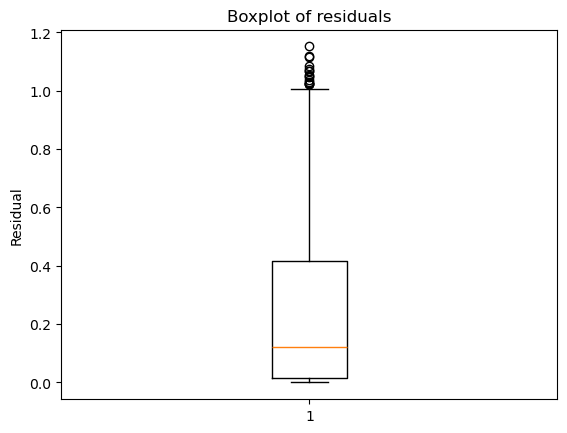

In [10]:
# now we use the Iterative Compensation Algorithm

populations = []

for i in tqdm(range(N_population)):
    if S[i] < M:
        populations.append([])
        continue
    p = generate_neuromodulated_population(M, V_th, g_s_targets[i], g_u_targets[i], set_to_compensate=['CaS', 'A'], iterations=2)
    populations.append(p)

# scatter plot of g_s - g_u, z = S
S = np.array([len(p) for p in populations])
df = pd.DataFrame({'g_s': g_s_targets, 'g_u': g_u_targets, 'z': S})

# Create a scatter plot of g_s - g_u, z = S
plt.figure()
plt.scatter(df['g_s'], df['g_u'], c=df['z'], cmap='viridis', s=1)
plt.colorbar(label='S')
plt.xlabel('g_s')
plt.ylabel('g_u')
plt.title('Scatter plot of S as function of g_s and g_u')
plt.show()

# compute the dics

residuals = []

for i in tqdm(range(N_population)):
    if len(populations[i]) < M:
        continue
    dics = DICs(V_th, *(populations[i].T), **get_default_parameters())
    dics = np.array(dics).squeeze()
    g_s = dics[1]
    g_u = dics[2]
    g = np.array([g_s, g_u])
    r = g - np.array([g_s_targets[i], g_u_targets[i]]).reshape(2, 1)
    r = np.linalg.norm(r, axis=0)  # norm L2
    residuals.append(np.mean(r))

# Histogram of the residuals
plt.figure()
plt.hist(residuals, bins='auto', density=True)
plt.xlabel('Residual')
plt.ylabel('Density')
plt.title('Histogram of residuals')
plt.show()

# Boxplot of the residuals
plt.figure()
plt.boxplot(residuals)
plt.ylabel('Residual')
plt.title('Boxplot of residuals')
plt.show()

residuals_iterative_2_it = residuals

100%|██████████| 5000/5000 [00:08<00:00, 605.10it/s]


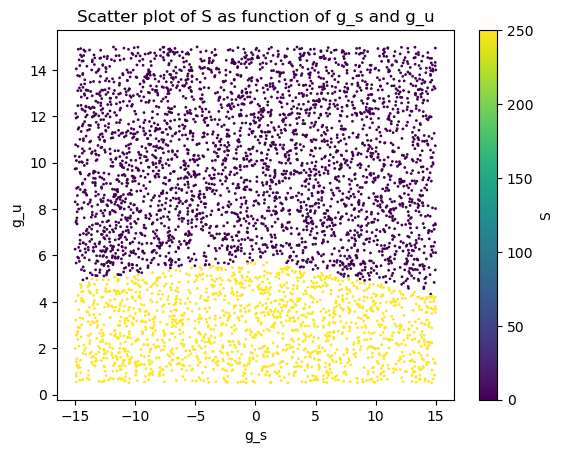

100%|██████████| 5000/5000 [00:01<00:00, 3189.79it/s]


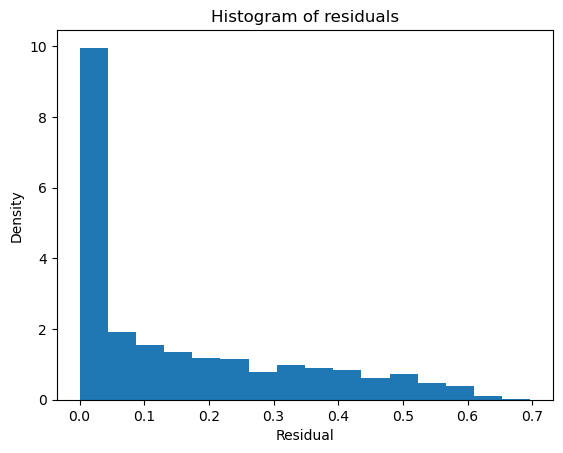

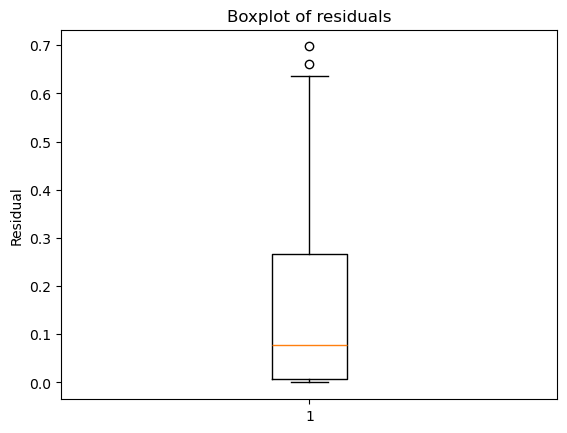

In [11]:
# now we use the Iterative Compensation Algorithm

populations = []

for i in tqdm(range(N_population)):
    if S[i] < M:
        populations.append([])
        continue
    p = generate_neuromodulated_population(M, V_th, g_s_targets[i], g_u_targets[i], set_to_compensate=['CaS', 'A'], iterations=3)
    populations.append(p)

# scatter plot of g_s - g_u, z = S
S = np.array([len(p) for p in populations])
df = pd.DataFrame({'g_s': g_s_targets, 'g_u': g_u_targets, 'z': S})

# Create a scatter plot of g_s - g_u, z = S
plt.figure()
plt.scatter(df['g_s'], df['g_u'], c=df['z'], cmap='viridis', s=1)
plt.colorbar(label='S')
plt.xlabel('g_s')
plt.ylabel('g_u')
plt.title('Scatter plot of S as function of g_s and g_u')
plt.show()

# compute the dics

residuals = []

for i in tqdm(range(N_population)):
    if len(populations[i]) < M:
        continue
    dics = DICs(V_th, *(populations[i].T), **get_default_parameters())
    dics = np.array(dics).squeeze()
    g_s = dics[1]
    g_u = dics[2]
    g = np.array([g_s, g_u])
    r = g - np.array([g_s_targets[i], g_u_targets[i]]).reshape(2, 1)
    r = np.linalg.norm(r, axis=0)  # norm L2
    residuals.append(np.mean(r))

# Histogram of the residuals
plt.figure()
plt.hist(residuals, bins='auto', density=True)
plt.xlabel('Residual')
plt.ylabel('Density')
plt.title('Histogram of residuals')
plt.show()

# Boxplot of the residuals
plt.figure()
plt.boxplot(residuals)
plt.ylabel('Residual')
plt.title('Boxplot of residuals')
plt.show()

residuals_iterative_3_it = residuals

100%|██████████| 5000/5000 [00:11<00:00, 440.13it/s]


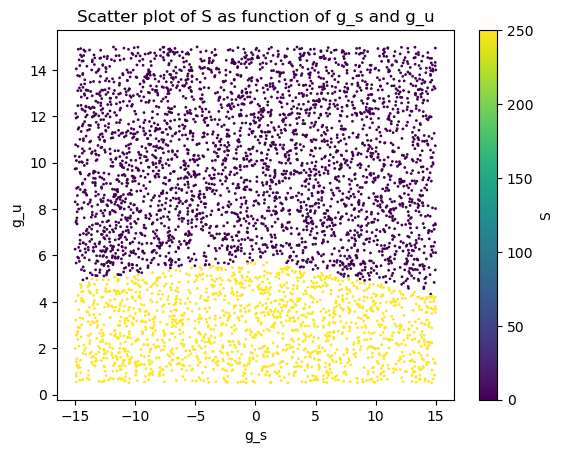

100%|██████████| 5000/5000 [00:01<00:00, 3104.96it/s]


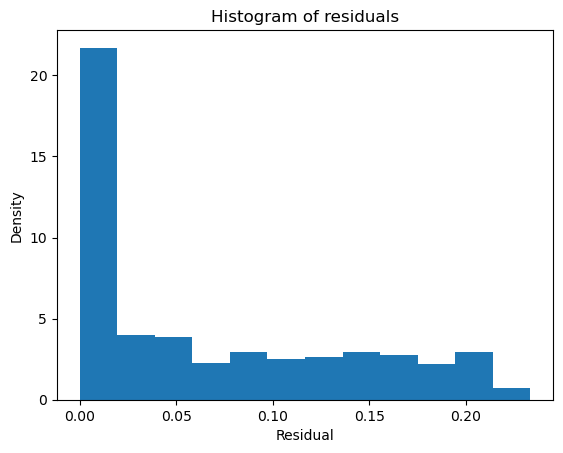

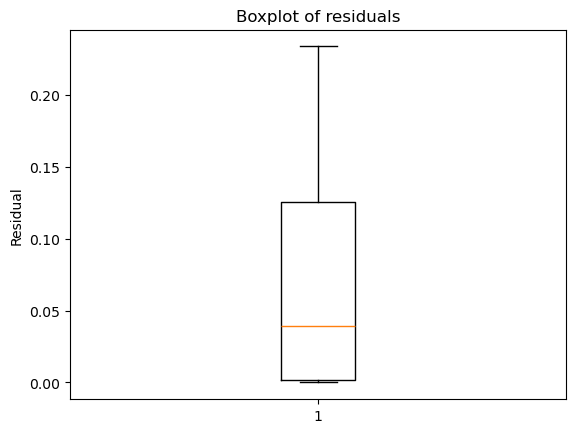

In [12]:
# now we use the Iterative Compensation Algorithm

populations = []

for i in tqdm(range(N_population)):
    if S[i] < M:
        populations.append([])
        continue
    p = generate_neuromodulated_population(M, V_th, g_s_targets[i], g_u_targets[i], set_to_compensate=['CaS', 'A'], iterations=5)
    populations.append(p)

# scatter plot of g_s - g_u, z = S
S = np.array([len(p) for p in populations])
df = pd.DataFrame({'g_s': g_s_targets, 'g_u': g_u_targets, 'z': S})

# Create a scatter plot of g_s - g_u, z = S
plt.figure()
plt.scatter(df['g_s'], df['g_u'], c=df['z'], cmap='viridis', s=1)
plt.colorbar(label='S')
plt.xlabel('g_s')
plt.ylabel('g_u')
plt.title('Scatter plot of S as function of g_s and g_u')
plt.show()

# compute the dics

residuals = []

for i in tqdm(range(N_population)):
    if len(populations[i]) < M:
        continue
    dics = DICs(V_th, *(populations[i].T), **get_default_parameters())
    dics = np.array(dics).squeeze()
    g_s = dics[1]
    g_u = dics[2]
    g = np.array([g_s, g_u])
    r = g - np.array([g_s_targets[i], g_u_targets[i]]).reshape(2, 1)
    r = np.linalg.norm(r, axis=0)  # norm L2
    residuals.append(np.mean(r))

# Histogram of the residuals
plt.figure()
plt.hist(residuals, bins='auto', density=True)
plt.xlabel('Residual')
plt.ylabel('Density')
plt.title('Histogram of residuals')
plt.show()

# Boxplot of the residuals
plt.figure()
plt.boxplot(residuals)
plt.ylabel('Residual')
plt.title('Boxplot of residuals')
plt.show()

residuals_iterative_5_it = residuals

100%|██████████| 5000/5000 [00:19<00:00, 254.49it/s]


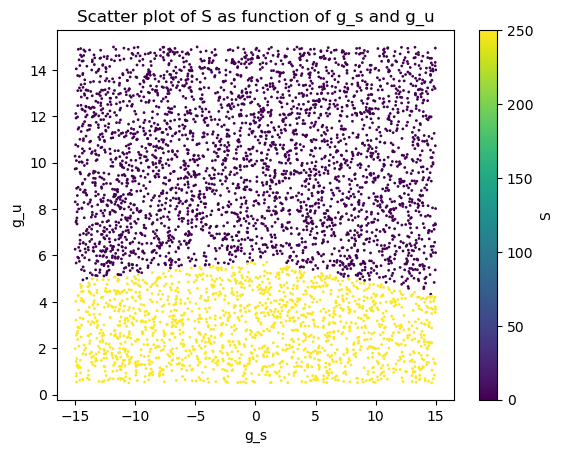

100%|██████████| 5000/5000 [00:01<00:00, 3196.27it/s]


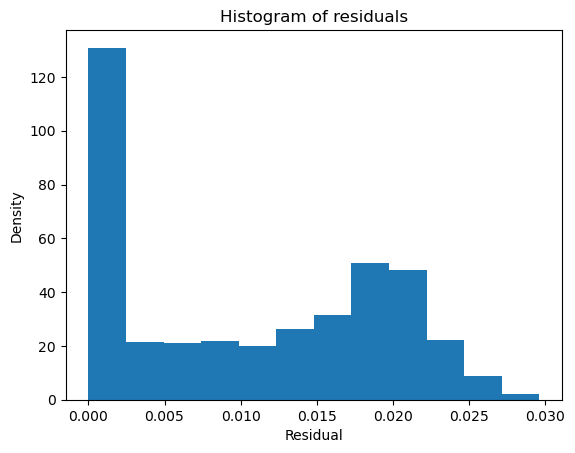

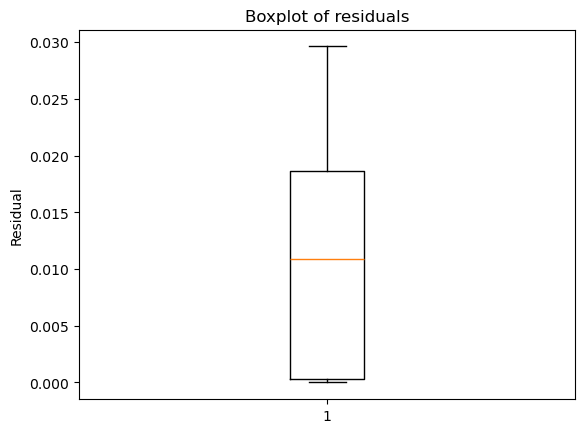

In [13]:
# now we use the Iterative Compensation Algorithm

populations = []

for i in tqdm(range(N_population)):
    if S[i] < M:
        populations.append([])
        continue
    p = generate_neuromodulated_population(M, V_th, g_s_targets[i], g_u_targets[i], set_to_compensate=['CaS', 'A'], iterations=10)
    populations.append(p)

# scatter plot of g_s - g_u, z = S
S = np.array([len(p) for p in populations])
df = pd.DataFrame({'g_s': g_s_targets, 'g_u': g_u_targets, 'z': S})

# Create a scatter plot of g_s - g_u, z = S
plt.figure()
plt.scatter(df['g_s'], df['g_u'], c=df['z'], cmap='viridis', s=1)
plt.colorbar(label='S')
plt.xlabel('g_s')
plt.ylabel('g_u')
plt.title('Scatter plot of S as function of g_s and g_u')
plt.show()

# compute the dics

residuals = []

for i in tqdm(range(N_population)):
    if len(populations[i]) < M:
        continue
    dics = DICs(V_th, *(populations[i].T), **get_default_parameters())
    dics = np.array(dics).squeeze()
    g_s = dics[1]
    g_u = dics[2]
    g = np.array([g_s, g_u])
    r = g - np.array([g_s_targets[i], g_u_targets[i]]).reshape(2, 1)
    r = np.linalg.norm(r, axis=0)  # norm L2
    residuals.append(np.mean(r))

# Histogram of the residuals
plt.figure()
plt.hist(residuals, bins='auto', density=True)
plt.xlabel('Residual')
plt.ylabel('Density')
plt.title('Histogram of residuals')
plt.show()

# Boxplot of the residuals
plt.figure()
plt.boxplot(residuals)
plt.ylabel('Residual')
plt.title('Boxplot of residuals')
plt.show()

residuals_iterative_10_it = residuals

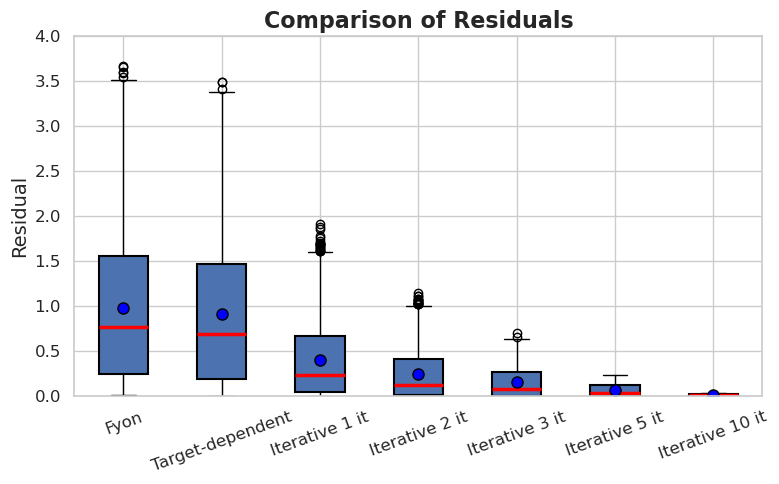

Mean residual Fyon: 0.9801
Mean residual Target-dependent: 0.9151
Mean residual Iterative 1 it: 0.4072
Mean residual Iterative 2 it: 0.2434
Mean residual Iterative 3 it: 0.1536
Mean residual Iterative 5 it: 0.0667
Mean residual Iterative 10 it: 0.0106


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Apply scientific paper-like styling
sns.set_theme(style="whitegrid")

# Data and labels
data = [
    residuals_fyon, residuals_target_dependent, residuals_iterative_1_it, 
    residuals_iterative_2_it, residuals_iterative_3_it, residuals_iterative_5_it, residuals_iterative_10_it
]
labels = ['Fyon', 'Target-dependent', 'Iterative 1 it', 'Iterative 2 it', 
          'Iterative 3 it', 'Iterative 5 it', 'Iterative 10 it']

# Create figure
plt.figure(figsize=(8, 5))

# Boxplot with enhanced aesthetics
boxprops = dict(linewidth=1.5, color="black")
medianprops = dict(linewidth=2.5, color="red")
meanprops = dict(marker="o", markerfacecolor="blue", markeredgecolor="black", markersize=8)

plt.boxplot(data, tick_labels=labels, patch_artist=True, boxprops=boxprops, medianprops=medianprops, meanprops=meanprops, showmeans=True)

# Labels and title
plt.ylabel('Residual', fontsize=14)
plt.title('Comparison of Residuals', fontsize=16, fontweight='bold')
plt.xticks(rotation=20, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 4)
# Save as high-quality SVG
plt.tight_layout()
plt.savefig('figures/comparison_residuals.svg', format='svg', bbox_inches='tight')
plt.show()

# Print mean residuals
for label, residual in zip(labels, data):
    print(f"Mean residual {label}: {np.mean(residual):.4f}")
